# Merging glaciers for past climate simulations

OGGM initializes glaciers based on [RGI outlines](https://www.glims.org/RGI/) which allows for fully automated simulations starting from a recent global glacier state. OGGM also treats every glacier as entity which basically means that individual glaciers do not know about each other even if they are modelled within one specific run.

This is a good approach for current and future simulations in a warming climate where we mainly expect glacier retreat. But if we want to look at colder climates, either from the past or in a synthetic way, we might have to adjust this glacier centric view and take the influence of neighbouring glaciers into account.

In this notebook we show how OGGM can merge several neighbouring glaciers into one coupled glacier system. The general approach for this is to view the surrounding glaciers in the same way as tributary [flowlines](https://docs.oggm.org/en/latest/flowlines.html) to an existing glacier entity.


**But before using this method please be aware of its limitations:** We are only able to merge glaciers which are present in the Randolph Glacier Inventory. This limits the time we can go back into the past as we are not able to *create* a glacier with OGGM at a place where there is no glacier today. The merging procedure was developed with typcial Alpine valley glaciers and their extends around the Little Ice Age in mind. We did not develop this with glacial time scales in mind and [this statement about long term glacier evolution](https://docs.oggm.org/en/latest/faq.html#can-i-use-oggm-to-simulate-long-term-glacier-evolution) still holds up.

## Set-up

These are the usual OGGM workflow commands.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os

from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core.flowline import FileModel

In [2]:
# Set-up
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-merging', reset=True)
# Use a suitable border size for your domain
cfg.PARAMS['border'] = 80
# This is useful here
cfg.PARAMS['use_multiprocessing'] = True

2021-02-03 13:40:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:40:19: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:40:19: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 13:40:20: oggm.cfg: PARAMS['border'] changed from `20` to `80`.


## Pick a main glacier and identify all its possible tributaries

In this case we are looking at Mont Mine Glacier (`RGI60-11.02709`) as our main glacier of interest.

In [3]:
montmine = workflow.init_glacier_directories(['RGI60-11.02709'], from_prepro_level=3)[0]

2021-02-03 13:40:25: oggm.workflow: init_glacier_directories from prepro level 3 on 1 glaciers.
2021-02-03 13:40:25: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
100% of 194.9 MiB |######################| Elapsed Time: 0:00:12 Time:  0:00:12


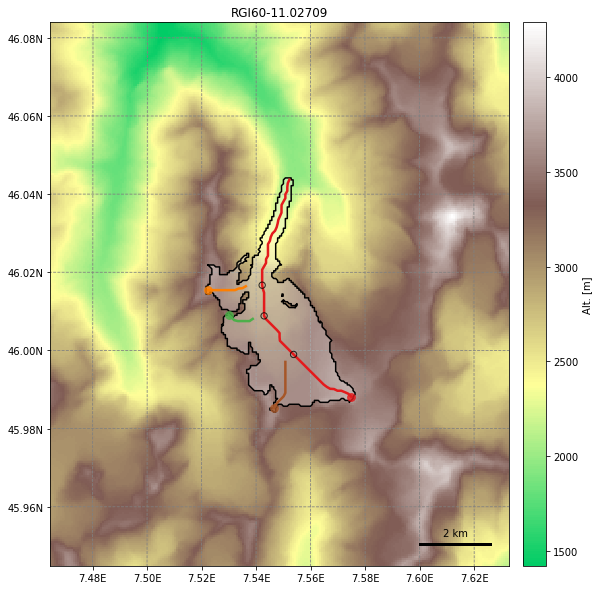

In [4]:
fig, ax = plt.subplots(figsize=[10,10])
graphics.plot_centerlines(montmine, ax=ax, use_flowlines=True);

At the moment it is not possible to automatically search for tributary glaciers but this is planed for a later release.

Right now we have to provide all **possible** tributary glaciers as OGGM GlacierDirectories. "Possible" because OGGM will check if the provided glaciers will actually flow together with the main glacier by intersecting their downstream flowlines. If a "false" glacier is provided, it will not be merged.

The easiest way to obtain the GlacierDirectories is by using [preprocessed glacier directories](http://docs.oggm.org/en/latest/input-data.html#pre-processed-directories), initialized with a list of RGI-IDs. The list of RGI-IDs can be manually made. Another way, more suitable for larger glacier complexes would be to extract the RGI-IDs directly from a RGI shapefile.
For the Mont Mine example we provide a subset, containing the surrounding glaciers.

That way it is possible to select and extract a region of interest from the RGI within a GIS software. OGGM will then test and merge all glacieres of this subset and use the feasible ones.


100% of  70.0 KiB |######################| Elapsed Time: 0:00:00 Time:  0:00:00


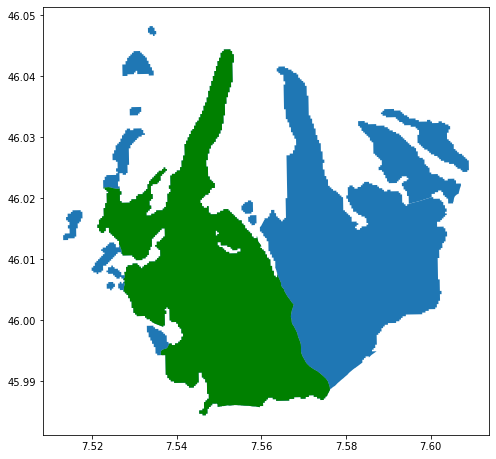

In [8]:
tfile = utils.file_downloader("https://cluster.klima.uni-bremen.de/~oggm/tutorials/montmine_shapefile.tar")
utils.robust_tar_extract(tfile, os.path.join(cfg.PATHS['working_dir'], 'shapefile/'))
basin = gpd.read_file(os.path.join(cfg.PATHS['working_dir'], 'shapefile', 'mont_mine.shp'))

# plot and highlight Mont Mine glacier in green
fig, ax = plt.subplots(figsize=[8,8])
basin.plot(ax=ax)
basin.loc[basin.RGIId=='RGI60-11.02709'].plot(ax=ax, color='green');

We can now use these RGI-IDs to initialize the OGGM GlacierDirectories.

In order to merge the glaciers we need the model flowlines and other files from **preprocessing level 3** which will be used by the dynamical model. The border size depends upon the specific topography and on how much glacier growth is expected. For the Mont Mine setting a border of 80 is sufficient.

Note that we also have to include the main glacier (Mont Mine glacier in this case) in the list of RGI-IDs.

In [12]:
# This can take some time
gdirs = workflow.init_glacier_directories(basin.RGIId.tolist(), from_prepro_level=3)
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2021-02-03 13:46:38: oggm.workflow: init_glacier_directories from prepro level 3 on 16 glaciers.
2021-02-03 13:46:38: oggm.workflow: Execute entity task gdir_from_prepro on 16 glaciers
2021-02-03 13:46:38: oggm.workflow: Execute entity task init_present_time_glacier on 16 glaciers


## Merging tributary glaciers to a main glacier

The merging process is fully automated done with the function `workflow.merge_glacier_tasks`.
It needs at least a list of OGGM GlacierDirectories, which contains all possible tributaries **and** the main glacier.
If as second argument a specific RGI ID is provided as string, this will be used to identify the main glacier of interest and all tributary glaciers are merged to this one. If no RGI ID is provided, OGGM will use the largest glacier as the main one. In the latter case the return value of the function is not a single GlacierDirectory but a list of GlacierDirectories containing all remaining glaciers, merged as much as possible.

This function also takes additional arguments to use custom climate data. The procedure for this would be to first run the necessary climate tasks on the individual glaciers and afterwards merge the glaciers to one complex. See the [API](http://docs.oggm.org/en/latest/generated/oggm.workflow.merge_glacier_tasks.html) for details.

`workflow.merge_glacier_tasks` performs three important tasks:
1. Starting from either the main or the largest glacier it checks if its downstream flowline intersects with the downstream flowlines of all other glaciers provided within the list.
2. It initializes a new OGGM GlacierDirectory for the merged glacier. This new glacier will have the RGI-ID of the main glacier with the suffix '_merged'. E.g. `RGI60-11.02709_merged` in this example. 
3. It merges the tributary glaciers (identified in step 1) to the main glacier.

In [14]:
cfg.PARAMS['use_intersects'] = False
gdirs_merged = workflow.merge_glacier_tasks(gdirs, 'RGI60-11.02709', return_all=False, filename='climate_historical')

2021-02-03 13:47:09: oggm.cfg: PARAMS['grid_dx_method'] changed from `square` to `fixed`.
2021-02-03 13:47:09: oggm.cfg: PARAMS['fixed_dx'] changed from `50.0` to `52.0`.
2021-02-03 13:47:10: oggm.cfg: PARAMS['grid_dx_method'] changed from `fixed` to `square`.
2021-02-03 13:47:10: oggm.cfg: PARAMS['fixed_dx'] changed from `52.0` to `50.0`.
2021-02-03 13:47:11: oggm.cfg: PARAMS['grid_dx_method'] changed from `square` to `fixed`.
2021-02-03 13:47:11: oggm.cfg: PARAMS['fixed_dx'] changed from `50.0` to `17.0`.
2021-02-03 13:47:11: oggm.cfg: PARAMS['grid_dx_method'] changed from `fixed` to `square`.
2021-02-03 13:47:11: oggm.cfg: PARAMS['fixed_dx'] changed from `17.0` to `50.0`.
2021-02-03 13:47:12: oggm.cfg: PARAMS['grid_dx_method'] changed from `square` to `fixed`.
2021-02-03 13:47:12: oggm.cfg: PARAMS['fixed_dx'] changed from `50.0` to `55.0`.
2021-02-03 13:47:13: oggm.cfg: PARAMS['grid_dx_method'] changed from `fixed` to `square`.
2021-02-03 13:47:13: oggm.cfg: PARAMS['fixed_dx'] chang

Let's have a look at the now merged glacier complex and compare it with the selected glaciers from the RGI shapefile:

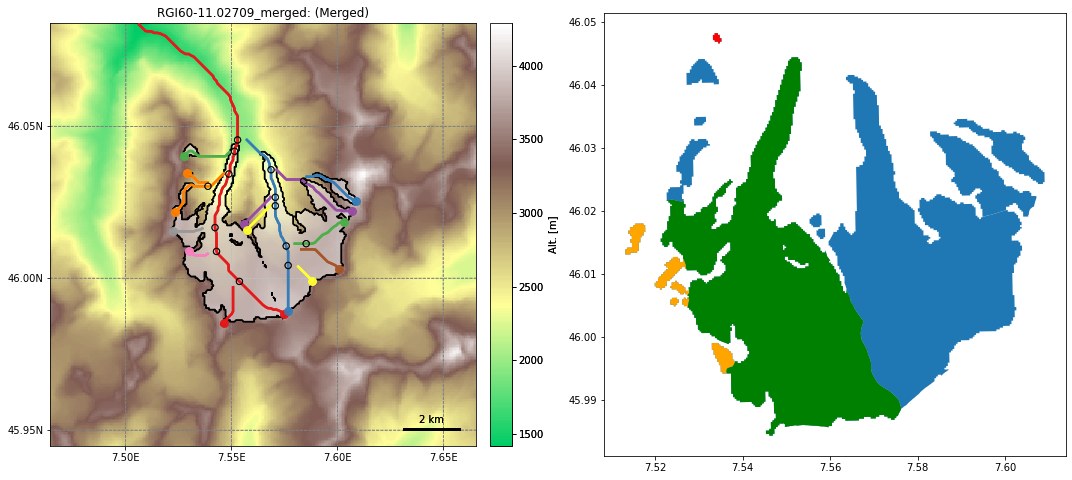

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,8])
graphics.plot_centerlines(gdirs_merged, ax=ax1, use_model_flowlines=True);
graphics.plot_centerlines(gdirs_merged, ax=ax1, use_model_flowlines=True);
basin.plot(ax=ax2)
basin.loc[basin.RGIId=='RGI60-11.02709'].plot(ax=ax2, color='green');
    
for rgiid in ['RGI60-11.02772', 'RGI60-11.02789', 'RGI60-11.02756', 'RGI60-11.02778', 'RGI60-11.02779', 'RGI60-11.02768']:
    basin.loc[basin.RGIId==rgiid].plot(ax=ax2, color='orange');    

basin.loc[basin.RGIId=='RGI60-11.02701'].plot(ax=ax2, color='red');
plt.tight_layout();

We see that several glaciers are now part of one big glacier complex, but we are also missing some:
- The green glacier ist our main glacier Mont Mine
- The blue glaciers are succesfully merged to the main glacier. Either directly or first to another glacier which itself tributes to Mont Mine.
- The orange glaciers do not flow into the same valley as Mont Mine glacier and were therefor correctly dismissed
- The red glacier could have been merged to Mont Mine, but it is small and to far away so its downstream line within its individual domain does not reach the downstream line of Mont Mine. It would be possible to solve this by using higher border values for this glacier.

## Influence on glacier advance

Merging two or more glaciers might become relevant for scenarios where you might expect an influence(or more specific: **mass contribution**) from one glacier to another. To test this effect we can model our main glacier Mont Mine as single *"entity"* glacier and a merged glacier complex.

We do this with constant climate but with a rather strong negative temperatur bias of -1°C. This will lead to a rapid glacier advance. 

In [17]:
# some model settings
years = 125
tbias = -1.5

# model Mont Mine glacier as entity and complile the output
tasks.run_constant_climate(montmine, nyears=years, output_filesuffix='_entity', temperature_bias=tbias)
ds_entity = utils.compile_run_output([montmine], path=False, filesuffix='_entity')

# model the merged glacier and complile the output
tasks.run_constant_climate(gdirs_merged, nyears=years, output_filesuffix='_merged', temperature_bias=tbias, climate_filename='climate_historical')
ds_merged = utils.compile_run_output([gdirs_merged], path=False, filesuffix='_merged')

2021-02-03 13:49:44: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-02-03 13:51:49: oggm.utils: Applying compile_run_output on 1 gdirs.


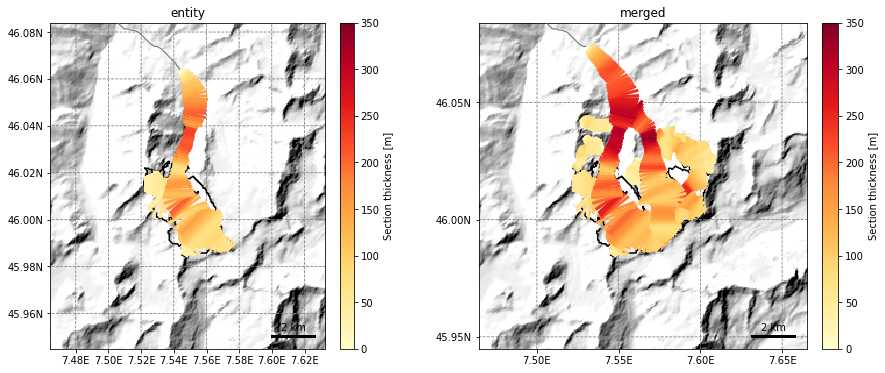

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])
graphics.plot_modeloutput_map(montmine, ax=ax1, filesuffix='_entity', modelyr=years, vmax=350, title='entity');
graphics.plot_modeloutput_map(gdirs_merged, ax=ax2, filesuffix='_merged', modelyr=years, vmax=350, title='merged');

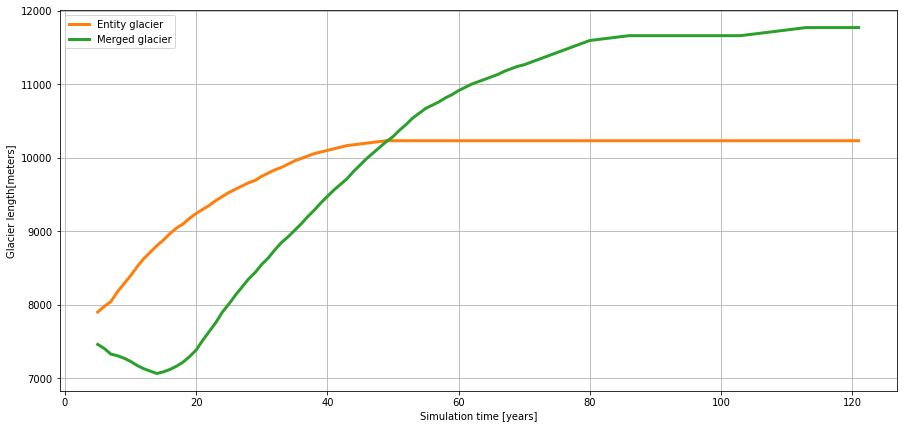

In [19]:
fig, ax = plt.subplots(figsize=[15,7])
dse = ds_entity.length.to_series().rolling(10, center=True).mean()
dsm = ds_merged.length.to_series().rolling(10, center=True).mean()
ax.plot(dse.values, 'C1', label='Entity glacier', linewidth=3)
ax.plot(dsm.values, 'C2', label='Merged glacier', linewidth=3)
ax.set_xlabel('Simulation time [years]')
ax.set_ylabel('Glacier length[meters]')
ax.grid(True)
ax.legend();

The difference betwee the two simulations is not immediately visible from the topographic plots as the domains are slightly different. But if we compare the glacier length change we see that after ~20 years in this climate scenario the merged glacier advances with a stronger rate. Around this point the tongues of Mont Mine and Ferpecle glacier in the east connect to one common tongue.

And after around 90 years the merged glacier shows an additional small advance. At that point some of the smaller tributary glaciers start to contribute mass.

## Influence on glacier retreat

We can also look at what influence a merged glacier has on glacier retreat.
For this we first try to grow the entity glacier to the same length as the merged glacer with a more negative temperature bias:

In [20]:
# some model settings
tbias = -2.25
years = 125

tasks.run_constant_climate(montmine, nyears=years, output_filesuffix='_entity1', temperature_bias=tbias)
ds_entity1 = utils.compile_run_output([montmine], path=False, filesuffix='_entity1');

2021-02-03 13:53:23: oggm.utils: Applying compile_run_output on 1 gdirs.


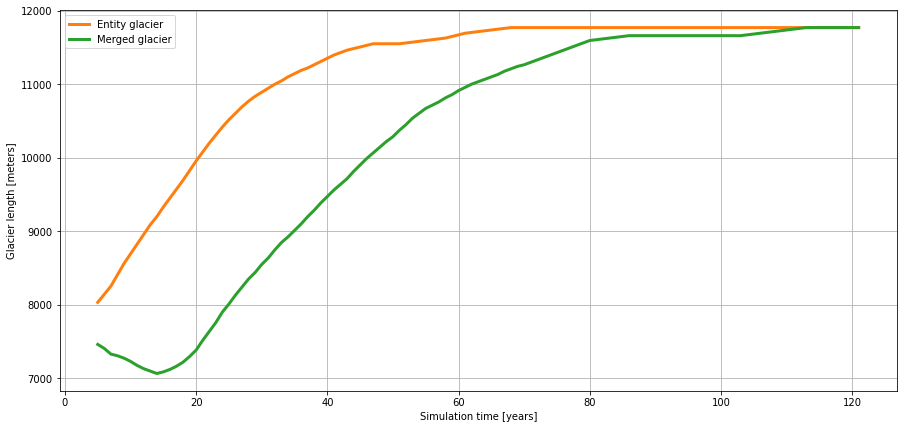

In [21]:
fig, ax = plt.subplots(figsize=[15,7])
dse1 = ds_entity1.length.to_series().rolling(10, center=True).mean()
ax.plot(dse1.values, 'C1', label='Entity glacier', linewidth=3)
ax.plot(dsm.values, 'C2', label='Merged glacier', linewidth=3)
ax.set_xlabel('Simulation time [years]')
ax.set_ylabel('Glacier length [meters]')
ax.grid(True)
ax.legend();

Now when both glaciers have roughly the same length we can let them shrink with a slightly warmer climate than before.
For this we use the simulated glacier extends from the previous runs and then apply the an identical climate to both glaciers.


In [23]:
# some model settings
tbias = -0.5
years = 100

# load the previous entity run 
tmp_mine = FileModel(montmine.get_filepath('model_run', filesuffix='_entity1'))
tmp_mine.run_until(years)

tasks.run_constant_climate(montmine, nyears=years, output_filesuffix='_entity2', init_model_fls=tmp_mine.fls,temperature_bias=tbias)
ds_entity2 = utils.compile_run_output([montmine], path=False, filesuffix='_entity2');

# model the merged glacier and complile the output
tmp_merged = FileModel(gdirs_merged.get_filepath('model_run', filesuffix='_merged'))
tmp_merged.run_until(years)

tasks.run_constant_climate(gdirs_merged, nyears=years, output_filesuffix='_merged2', init_model_fls=tmp_merged.fls, temperature_bias=tbias,
                           climate_filename='climate_historical')
ds_merged2 = utils.compile_run_output([gdirs_merged], path=False, filesuffix='_merged2')


2021-02-03 13:54:51: oggm.utils: Applying compile_run_output on 1 gdirs.
2021-02-03 13:56:16: oggm.utils: Applying compile_run_output on 1 gdirs.


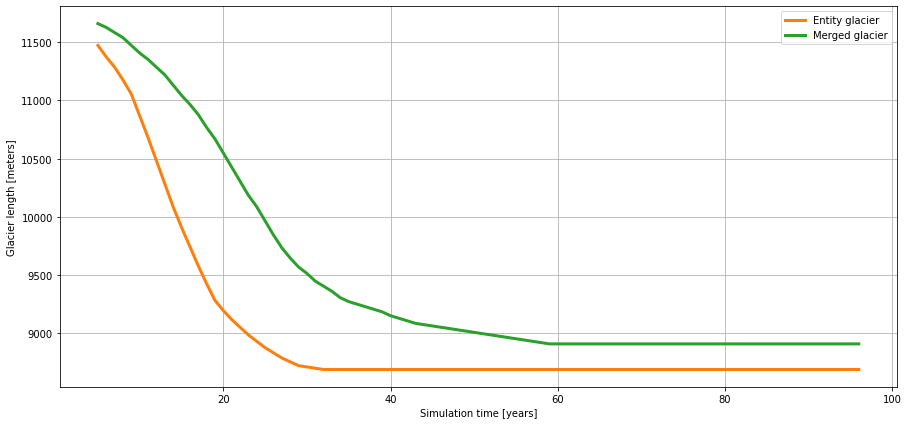

In [24]:
fig, ax = plt.subplots(figsize=[15,7])
dse2 = ds_entity2.length.to_series().rolling(10, center=True).mean()
dsm2 = ds_merged2.length.to_series().rolling(10, center=True).mean()
ax.plot(dse2.values, 'C1', label='Entity glacier', linewidth=3)
ax.plot(dsm2.values, 'C2', label='Merged glacier', linewidth=3)
ax.set_xlabel('Simulation time [years]')
ax.set_ylabel('Glacier length [meters]')
ax.grid(True)
ax.legend();

Starting from roughly the same extend, the entity glacier retreats much faster than the merged one, especially during the first 20 years. After that the rates of retreat seem more similar. But it takes more then 80 years until both glaciers are back to the same extend.

Reaching the same extent in the end is to be exected, as the tributaries stop contributing mass to the merged Mont Mine at some point.

## Known problems, future improvements and limitations

- In future OGGM should be able to automatically identify tributary glaciers in a given distance
- Currently some glaciers are not merged as their downstream line does not reach the main glacier's line. This is especially the case for smaller tributary glaciers, as their domain is also smaller.
- Glacier length in OGGM is calculated as the glaciated length of the main flowline. Usually this will also work for merged glaciers. But there are scenarios where merging glaciers might produce unexpected results: If a tributary glacier is contributing mass to the main glaciers downstream flowline but the main glacier did not already advance up to the tributary glacier (or has retreated again) the OGGM glacier length will be the sum of all glaciated parts on the main flowline. 
- Glacier area and volume in OGGM are calculated from all parts of the individual glacier. For a merged glacier all tributary glaciers are added to the total area and volume, even if they are not or were never connected to the actual main glacier.

Especially the last two points show that even if merging glaciers will become a fully automated task in OGGM it should not be used without carfully assessing the results. Model results for merged glaciers might contain logical errors which are not obvious if only pure numbers (e.g. volume change) are evaluated. 

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)